In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import json
import time as time

import shapefile
from json import dumps

import folium

ImportError: No module named 'folium'

## import shapefile and extract zipcodes

In [2]:
import geopandas as gpd
import matplotlib.pyplot as mplt

In [3]:
canada_shp = gpd.read_file('C:/Users/omid/Desktop/Amazon Project/ShapeFile/lfsa000b16a_e.shp')

In [16]:
df_zipcodes_census = pd.read_excel('ZipCode Canada Amazon Coverage.xlsx')

In [17]:
df_zipcodes_census.tail()

,ZipCode,No Covereage,Covereage,Zip Code short
1615,V6R 1G7,0,1,V6R
1616,T6V 1G7,0,1,T6V
1617,T6E 1G7,0,1,T6E
1618,T6G 1G7,0,1,T6G
1619,V3B 1G7,0,1,V3B


{'Alberta',
 'British Columbia / Colombie-Britannique',
 'Manitoba',
 'New Brunswick / Nouveau-Brunswick',
 'Newfoundland and Labrador / Terre-Neuve-et-Labrador',
 'Northwest Territories / Territoires du Nord-Ouest',
 'Nova Scotia / Nouvelle-Écosse',
 'Nunavut',
 'Ontario',
 'Prince Edward Island / Île-du-Prince-Édouard',
 'Quebec / Québec',
 'Saskatchewan',
 'Yukon'}

In [47]:
canada_shp.tail()

,CFSAUID,PRUID,PRNAME,geometry
1615,V6R,59,British Columbia / Colombie-Britannique,POLYGON ((-123.2155596081461 49.27665180706205...
1616,T6V,48,Alberta,POLYGON ((-113.5777859180089 53.63232402499366...
1617,T6E,48,Alberta,"POLYGON ((-113.4938945225957 53.5262445913987,..."
1618,T6G,48,Alberta,POLYGON ((-113.5120714900105 53.51616891093779...
1619,V3B,59,British Columbia / Colombie-Britannique,POLYGON ((-122.8035718916259 49.29492269662806...


In [18]:
canada_shp_coverage = pd.merge(canada_shp, df_zipcodes_census[['Covereage','Zip Code short']], left_on = 'CFSAUID', right_on = 'Zip Code short', how = 'left') 

In [20]:
canada_shp_coverage.tail()

,CFSAUID,PRUID,PRNAME,geometry,Covereage,Zip Code short
1615,V6R,59,British Columbia / Colombie-Britannique,POLYGON ((-123.2155596081461 49.27665180706205...,1,V6R
1616,T6V,48,Alberta,POLYGON ((-113.5777859180089 53.63232402499366...,1,T6V
1617,T6E,48,Alberta,"POLYGON ((-113.4938945225957 53.5262445913987,...",1,T6E
1618,T6G,48,Alberta,POLYGON ((-113.5120714900105 53.51616891093779...,1,T6G
1619,V3B,59,British Columbia / Colombie-Britannique,POLYGON ((-122.8035718916259 49.29492269662806...,1,V3B


In [21]:
df_zipcodes_pop = pd.read_excel('CA_pop.xlsx')

In [22]:
df_zipcodes_pop.head()

,Geographic code,Geographic name,Province or territory,"Population, 2016"
0,A0A,A0A,Newfoundland and Labrador,46587
1,A0B,A0B,Newfoundland and Labrador,19792
2,A0C,A0C,Newfoundland and Labrador,12587
3,A0E,A0E,Newfoundland and Labrador,22294
4,A0G,A0G,Newfoundland and Labrador,35266


In [24]:
df_zipcodes_pop[df_zipcodes_pop.loc[:,'Geographic code'] != df_zipcodes_pop.loc[:,'Geographic name']]

,Geographic code,Geographic name,Province or territory,"Population, 2016"


In [26]:
canada_shp_coverage_pop = pd.merge(canada_shp_coverage, df_zipcodes_pop[['Geographic code','Province or territory','Population, 2016']], left_on = 'CFSAUID', right_on = 'Geographic code', how = 'left') 

In [34]:
canada_shp_coverage_pop.dtypes

CFSAUID                  object
PRUID                    object
PRNAME                   object
geometry                 object
Covereage                 int64
Zip Code short           object
Geographic code          object
Province or territory    object
Population, 2016          int64
dtype: object

In [33]:
canada_shp_coverage_pop = canada_shp_coverage_pop.set_geometry('geometry')

In [35]:
canada_shp_coverage_pop.to_file('canada_shp_coverage_pop.shp')

In [9]:
canada_shp.crs

{'init': 'epsg:4326'}

In [6]:
canada_shp = canada_shp.to_crs({'init' :'epsg:4326'})

In [8]:
canada_shp = canada_shp.set_geometry('geometry')

<Figure size 720x720 with 0 Axes>

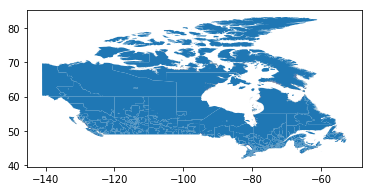

In [11]:
canada_shp.plot(
mplt.gcf().set_size_inches( 10, 10)

In [36]:
canada_shp.to_file('canada.shp')

In [38]:
# read the shapefile
reader = shapefile.Reader ("canada_shp_coverage_pop.shp", encoding='latin-1')

## Convert shapefile to json
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", \
    geometry=geom, properties=atr)) 

# write the GeoJSON file
geojson = open("canada_shp_coverage_pop.json", "w")
geojson.write(dumps({"type": "FeatureCollection", "features": buffer}, indent=2) + "\n")
geojson.close()

In [41]:
## Load GEOJSON
with open ('canada_shp_coverage_pop.json', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

In [47]:
## Extracting All the Canada ZipCodes

## Load GEOJSON
with open ('Canada_zipcodes.json', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

zipcodes_census = []
for i in range(len(tmp['features'])):
    zipcodes_census.append(tmp['features'][i]['properties']['CFSAUID'])    

In [64]:
## Creatubg 6 digit ZipCodes for Amazon

zipcodes_census_6digit = []
for i in range(len(zipcodes_census)):
    zipcodes_census_6digit.append(zipcodes_census[i]+' 1G7')

In [66]:
df_zipcodes_census = pd.DataFrame({'ZipCode':zipcodes_census_6digit})

### Now put data

In [156]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument("--headless")

browser = webdriver.Chrome(executable_path = r'C:/Users/omid/Desktop/Amazon Project/chromedriver_win32/chromedriver.exe',
                           options = chrome_options)

In [157]:
df_zipcodes_census['No Covereage'] = 0
df_zipcodes_census['Covereage'] = 0

In [158]:
browser.get('https://www.amazon.ca/b?ie=UTF8&node=9863204011')

## Find the location of the search bar
searchbar = browser.find_element_by_id('free_same_day_zip_checker_input')

In [159]:
for i in range (0, df_zipcodes_census.shape[0]):
    if i % 50 == 0:
        print(i , 'zip code completed and' , df_zipcodes_census.shape[0]-i,' zip code remains.')
    if i % 100 == 0:
        df_zipcodes_census.to_excel('C:/Users/omid/Desktop/Amazon Project/ZipCode Canada Amazon Coverage.xlsx',sheet_name = 'sheet1',index = False)
        #writer = pd.ExcelWriter('output.xlsx')
    ## Search for ZipCode
    searchbar.send_keys(df_zipcodes_census.loc[i,'ZipCode'])

    ## Enter the zipcode and begin the search
    searchbar.send_keys(Keys.ENTER)

    time.sleep(0.9)

    ## Capturing the result
    result = browser.find_element_by_id('free_same_day_zip_checker_message_2')

    if result.text.find('Prime Free Same-Day or Free One-Day Delivery is available for residential addresses in') != -1:
        df_zipcodes_census.loc[i, 'Covereage'] = 1
    elif result.text.find('is not within the Prime Free Same-Day or Free One-Day Delivery areas.') != -1:
        df_zipcodes_census.loc[i, 'No Covereage'] = 1  
    
    ## Find the location of the search bar and Clear text from text area 
    browser.find_element_by_id('free_same_day_zip_checker_input').clear()

0 zip code completed and 1620  zip code remains.
50 zip code completed and 1570  zip code remains.
100 zip code completed and 1520  zip code remains.
150 zip code completed and 1470  zip code remains.
200 zip code completed and 1420  zip code remains.
250 zip code completed and 1370  zip code remains.
300 zip code completed and 1320  zip code remains.
350 zip code completed and 1270  zip code remains.
400 zip code completed and 1220  zip code remains.
450 zip code completed and 1170  zip code remains.
500 zip code completed and 1120  zip code remains.
550 zip code completed and 1070  zip code remains.
600 zip code completed and 1020  zip code remains.
650 zip code completed and 970  zip code remains.
700 zip code completed and 920  zip code remains.
750 zip code completed and 870  zip code remains.
800 zip code completed and 820  zip code remains.
850 zip code completed and 770  zip code remains.
900 zip code completed and 720  zip code remains.
950 zip code completed and 670  zip code

### Map the result

In [128]:
df_zipcodes_census['Zip Code short'] = zipcodes_census

In [129]:
df_zipcodes_census.head()

,ZipCode,No Covereage,Covereage,Zip Code short
0,B1E 1G7,1,0,B1E
1,B1G 1G7,1,0,B1G
2,B1H 1G7,1,0,B1H
3,B1J 1G7,1,0,B1J
4,B1K 1G7,1,0,B1K


### Finding Lat and Lng for ZipCodes

In [3]:
df_zipcodes_census = pd.read_excel('ZipCode Canada Amazon Coverage.xlsx')

In [4]:
df_zipcodes_census.head()

,ZipCode,No Covereage,Covereage,Zip Code short
0,B1E 1G7,1,0,B1E
1,B1G 1G7,1,0,B1G
2,B1H 1G7,1,0,B1H
3,B1J 1G7,1,0,B1J
4,B1K 1G7,1,0,B1K


In [30]:
df_zipcodes_lat_lng = pd.read_excel('ca_postal_codes2.xlsx')

In [31]:
df_zipcodes_lat_lng = df_zipcodes_lat_lng.loc[:,['Postal Code','Province','Latitude','Longitude']]

In [32]:
df_zipcodes_lat_lng.head()

,Postal Code,Province,Latitude,Longitude
0,T0A,AB,54.7660,-111.7174
1,T0B,AB,53.0727,-111.5816
2,T0C,AB,52.1431,-111.6941
3,T0E,AB,53.6758,-115.0948
4,T0G,AB,55.6993,-114.4529


In [33]:
df_zipcodes_total = pd.merge(df_zipcodes_census, df_zipcodes_lat_lng, left_on = 'Zip Code short', right_on = 'Postal Code', how = 'inner')

In [34]:
df_zipcodes_total.tail()

,ZipCode,No Covereage,Covereage,Zip Code short,Postal Code,Province,Latitude,Longitude
1607,V6R 1G7,0,1,V6R,V6R,BC,49.2666,-123.1976
1608,T6V 1G7,0,1,T6V,T6V,AB,53.6112,-113.5746
1609,T6E 1G7,0,1,T6E,T6E,AB,53.4914,-113.4802
1610,T6G 1G7,0,1,T6G,T6G,AB,53.5210,-113.5324
1611,V3B 1G7,0,1,V3B,V3B,BC,49.2740,-122.7649


In [41]:
df_zipcodes_total.to_excel('C:/Users/omid/Desktop/Amazon Project/Amazon Colab.xlsx',sheet_name = 'sheet1',index = False)

In [35]:
df_zipcodes_total.dtypes

ZipCode            object
No Covereage        int64
Covereage           int64
Zip Code short     object
Postal Code        object
Province           object
Latitude          float64
Longitude         float64
dtype: object

In [40]:
set(df_zipcodes_total.loc[:,'Covereage'].tolist())

{0, 1}

In [ ]:
folium.

### Mapping the coordinates

In [42]:
m = folium.Map(location = [43.653963, -79.387207], zoom_start = 4)

for i in range(df_zipcodes_total.shape[0]):
    if df_zipcodes_total.loc[i,'Covereage'] == 1:
        folium.Circle([df_zipcodes_total.loc[i,'Latitude'],df_zipcodes_total.loc[i,'Longitude']], color = 'Red', radius = 100,
                      fill = True, popup = df_zipcodes_total.loc[i,'Postal Code']+', '+df_zipcodes_total.loc[i,'Province']).add_to(m)

display(m)

### Extracting Ontario

In [43]:
df_zipcodes_census_map=pd.DataFrame(columns = df_zipcodes_census.columns)
for i in range(df_zipcodes_census.shape[0]):
    if df_zipcodes_census.loc[i,'Zip Code short'][0] in ['K','L','M','N']:
        df_zipcodes_census_map = df_zipcodes_census_map.append(df_zipcodes_census.loc[i,:],ignore_index = True, sort = False)

In [44]:
df_zipcodes_census_map.tail()

,ZipCode,No Covereage,Covereage,Zip Code short
450,N7X 1G7,1,0,N7X
451,N5R 1G7,1,0,N5R
452,L1V 1G7,0,1,L1V
453,L1W 1G7,0,1,L1W
454,L1X 1G7,0,1,L1X


In [ ]:
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['CFSAUID'] in df_zipcodes_census_map['Zip Code short'].tolist():
        geozips.append(tmp['features'][i])

In [49]:
df_zipcodes_census_map.loc[:,'Covereage'] = df_zipcodes_census_map.loc[:,'Covereage'].astype(float)

In [46]:
df_zipcodes_census.dtypes

ZipCode           object
No Covereage       int64
Covereage          int64
Zip Code short    object
dtype: object

In [43]:
tmp['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-60.003588887847016, 46.19294149911977],
    [-60.00349463414635, 46.19276800254645],
    [-60.00339158903292, 46.19275630543557],
    [-60.0032077380563, 46.19256246727429],
    [-60.00304485349606, 46.192459201222285],
    [-60.00312794189812, 46.1920496139184],
    [-60.00318652817432, 46.19176086669785],
    [-60.00334452829598, 46.19147699275793],
    [-60.0037555353159, 46.19035371182759],
    [-60.00379316426577, 46.19013867180372],
    [-60.00361543596245, 46.1895940011589],
    [-60.00385864028822, 46.18941134611839],
    [-60.00398613381218, 46.188496650526844],
    [-60.00392779552409, 46.188378111332014],
    [-60.00388705119987, 46.18793601419867],
    [-60.00356648122842, 46.18739657127061],
    [-60.003567703171065, 46.18713557147457],
    [-60.00360601174189, 46.18707999480789],
    [-60.0037505930737, 46.186870355709345],
    [-60.003346214146674, 46.18643110366412],
    [-60.003484540999544, 46.1

In [45]:
la_geo = r'canada_shp_coverage_pop.json'

m = folium.Map(location = [43.653963, -79.387207], zoom_start = 4, tiles = 'OpenStreetMap')

m.choropleth(
    geo_data = la_geo,
    fill_opacity = 0.4,
    line_opacity = 0.1,
    data = df_zipcodes_census,
    key_on = 'feature.properties.CFSAUID',
    columns = ['Zip Code short','Covereage'],
    fill_color = 'YlOrRd')
folium.LayerControl().add_to(m)

m.save(outfile = 'Amazon_covereage.html')

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Creating Map for each province

In [95]:
canada_shp_coverage_pop_bc = canada_shp_coverage_pop[canada_shp_coverage_pop['PRNAME'] == 'British Columbia / Colombie-Britannique']

In [96]:
canada_shp_coverage_pop_bc.head(2)

,CFSAUID,PRUID,PRNAME,geometry,Covereage,Zip Code short,Geographic code,Province or territory,"Population, 2016"
805,V8V,59,British Columbia / Colombie-Britannique,POLYGON ((-123.3862666003228 48.42357879820062...,1,V8V,V8V,British Columbia,25892
806,V9M,59,British Columbia / Colombie-Britannique,"POLYGON ((-124.927600707368 49.73990578992542,...",0,V9M,V9M,British Columbia,17208


In [97]:
canada_shp_coverage_pop_bc.loc[:,'Population, 2016'].sum()

4648050

In [98]:
canada_shp_coverage_pop_bc[canada_shp_coverage_pop_bc['Covereage']==1].loc[:,'Population, 2016'].sum()

2988926

In [80]:
print(canada_shp_coverage_pop_QC.shape)

print(set(canada_shp_coverage_pop_QC['Province or territory'].tolist()))

canada_shp_coverage_pop_QC = canada_shp_coverage_pop_QC.to_crs({'init' :'epsg:4326'})

canada_shp_coverage_pop_QC = canada_shp_coverage_pop_QC.set_geometry('geometry')

#canada_shp_coverage_pop_ON.plot()
#mplt.gcf().set_size_inches( 10, 10)

canada_shp_coverage_pop_QC.to_file('canada_QC.shp')

# read the shapefile
reader = shapefile.Reader ("canada_QC.shp", encoding='latin-1')

## Convert shapefile to json
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", \
    geometry=geom, properties=atr)) 

# write the GeoJSON file
geojson = open("canada_QC.json", "w")
geojson.write(dumps({"type": "FeatureCollection", "features": buffer}, indent=2) + "\n")
geojson.close()

la_geo = r'canada_QC.json'

m = folium.Map(location = [45.516136, -73.656830], zoom_start = 5, tiles = 'OpenStreetMap')

m.choropleth(
    geo_data = la_geo,
    fill_opacity = 0.4,
    line_opacity = 0.15,
    data = df_zipcodes_census,
    key_on = 'feature.properties.CFSAUID',
    columns = ['Zip Code short','Covereage'],
    fill_color = 'YlOrRd')
folium.LayerControl().add_to(m)

m.save(outfile = 'Amazon_covereage_QC.html')

(413, 9)
{'Quebec'}


C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [64]:
set(canada_shp['PRNAME'].tolist())

{'Alberta',
 'British Columbia / Colombie-Britannique',
 'Manitoba',
 'New Brunswick / Nouveau-Brunswick',
 'Newfoundland and Labrador / Terre-Neuve-et-Labrador',
 'Northwest Territories / Territoires du Nord-Ouest',
 'Nova Scotia / Nouvelle-Écosse',
 'Nunavut',
 'Ontario',
 'Prince Edward Island / Île-du-Prince-Édouard',
 'Quebec / Québec',
 'Saskatchewan',
 'Yukon'}

In [ ]:
canada_shp_coverage_pop_bc= canada_shp_coverage_pop[canada_shp_coverage_pop['PRNAME'] == 'British Columbia / Colombie-Britannique']

In [69]:
canada_shp_coverage_pop_bc.shape

(189, 9)

In [70]:
set(canada_shp_coverage_pop_bc['Province or territory'].tolist())

{'British Columbia'}

In [53]:
canada_shp_coverage_pop_alberta = canada_shp_coverage_pop_alberta.to_crs({'init' :'epsg:4326'})

In [54]:
canada_shp_coverage_pop_alberta = canada_shp_coverage_pop_alberta.set_geometry('geometry')

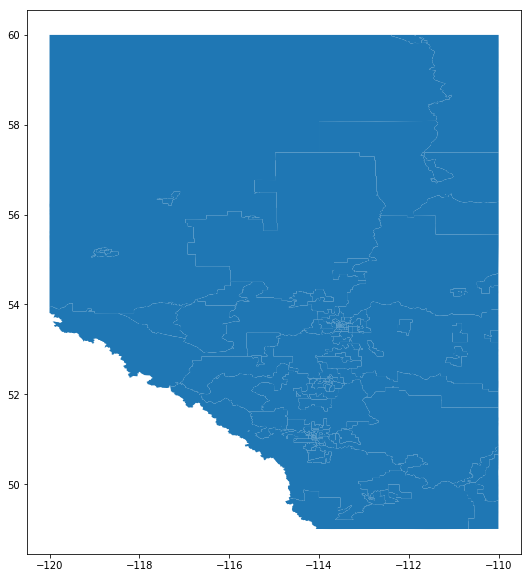

In [56]:
canada_shp_coverage_pop_alberta.plot()
mplt.gcf().set_size_inches( 10, 10)

In [57]:
canada_shp_coverage_pop_alberta.to_file('canada_Alberta.shp')

In [58]:
# read the shapefile
reader = shapefile.Reader ("canada_Alberta.shp", encoding='latin-1')

## Convert shapefile to json
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", \
    geometry=geom, properties=atr)) 

# write the GeoJSON file
geojson = open("canada_Alberta.json", "w")
geojson.write(dumps({"type": "FeatureCollection", "features": buffer}, indent=2) + "\n")
geojson.close()

In [63]:
la_geo = r'canada_Alberta.json'

m = folium.Map(location = [56.90, -115.00], zoom_start = 5, tiles = 'OpenStreetMap')

m.choropleth(
    geo_data = la_geo,
    fill_opacity = 0.4,
    line_opacity = 0.15,
    data = df_zipcodes_census,
    key_on = 'feature.properties.CFSAUID',
    columns = ['Zip Code short','Covereage'],
    fill_color = 'YlOrRd')
folium.LayerControl().add_to(m)

m.save(outfile = 'Amazon_covereage_Alberta.html')

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [49]:
canada_shp_coverage_pop.head()

,CFSAUID,PRUID,PRNAME,geometry,Covereage,Zip Code short,Geographic code,Province or territory,"Population, 2016"
0,B1E,12,Nova Scotia / Nouvelle-Écosse,POLYGON ((-60.00358888784702 46.19294149911977...,0,B1E,B1E,Nova Scotia,1564
1,B1G,12,Nova Scotia / Nouvelle-Écosse,POLYGON ((-60.00298191294156 46.21909911713896...,0,B1G,B1G,Nova Scotia,1867
2,B1H,12,Nova Scotia / Nouvelle-Écosse,POLYGON ((-60.04267195814499 46.24853912241313...,0,B1H,B1H,Nova Scotia,9642
3,B1J,12,Nova Scotia / Nouvelle-Écosse,(POLYGON ((-60.29129717887312 46.0744106391265...,0,B1J,B1J,Nova Scotia,969
4,B1K,12,Nova Scotia / Nouvelle-Écosse,(POLYGON ((-59.99001099386792 46.1016148936142...,0,B1K,B1K,Nova Scotia,3049
